# Tool Window Usage Analysis

## Pipeline Overview

1. **Error Diagnostics** — Profile event quality, quantify orphans and consecutive opens/closes, analyze O-O timing signatures.
2. **Baseline (Last-Open-Wins)** — Derive sessions with LOW heuristic, compute durations, run Mann–Whitney U test.
3. **LIFO Stack** — Reconstruct sessions with LIFO stack to correctly resolve nested O-O-C sequences without circular heuristics.
4. **Timeout Capping** — Apply 99th-percentile cap to LIFO durations and re-test with Welch's t-test to verify robustness against extreme outliers.
5. **Final Report** — Statistical findings.

In [132]:
import subprocess
import sys
from pathlib import Path
from typing import Any, Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import warnings

warnings.filterwarnings('ignore')

def ensure_package(package_name: str) -> None:
    try:
        __import__(package_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

ensure_package('pingouin')
import pingouin as pg

sns.set_theme(style='whitegrid')
plt.rcParams.update({'figure.figsize': (10, 6), 'axes.titlesize': 14, 'axes.labelsize': 12})
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.4f}'.format)
np.random.seed(42)

## Part 1 · Error Diagnostics

Load raw event log, normalize timestamps, quantify sequential errors, and diagnose O-O timing patterns.

In [133]:
DATA_PATH = Path('toolwindow_data.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Expected dataset at {DATA_PATH.resolve()}")

df = pd.read_csv(DATA_PATH)
expected_columns = {'timestamp', 'event', 'open_type', 'user_id'}
missing_columns = expected_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing required columns: {sorted(missing_columns)}")

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
df = df.dropna(subset=['timestamp'])
df_sorted = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

print(f"Total events: {len(df_sorted):,}")
print(f"Unique users: {df_sorted['user_id'].nunique():,}")
display(df_sorted.head())

Total events: 3,503
Unique users: 205


,timestamp,event,open_type,user_id
0,2025-07-06 18:21:42.123,opened,auto,1
1,2025-07-06 18:32:26.077,closed,NaN,1
2,2025-07-06 22:34:18.635,opened,manual,1
3,2025-07-07 00:52:24.609,closed,NaN,1
4,2025-07-08 14:38:07.772,opened,manual,1


### Orphan Open/Close Diagnostics

Profile orphaned events: closes without preceding opens, and trailing opens at the end of user streams.

In [134]:
session_anomalies: List[Dict[str, Any]] = []
for user_id, timeline in df_sorted.groupby('user_id', sort=False):
    open_stack: List[pd.Series] = []
    for row in timeline.itertuples(index=False):
        if row.event == 'opened':
            open_stack.append(row)
        elif row.event == 'closed':
            if open_stack:
                open_stack.pop()
            else:
                session_anomalies.append({
                    'user_id': row.user_id,
                    'timestamp': row.timestamp,
                    'issue': 'close_without_open',
                    'open_type': row.open_type
                })
    while open_stack:
        open_row = open_stack.pop(0)
        session_anomalies.append({
            'user_id': open_row.user_id,
            'timestamp': open_row.timestamp,
            'issue': 'open_without_close',
            'open_type': open_row.open_type
        })

session_anomalies_df = pd.DataFrame(session_anomalies)
if session_anomalies_df.empty:
    print('No orphaned open/close anomalies detected.')
    close_without_open = 0
    open_without_close = 0
else:
    anomaly_summary = (
        session_anomalies_df.groupby(['issue', 'open_type'])
        .size()
        .rename('count')
        .reset_index()
        .sort_values('count', ascending=False)
    )
    display(anomaly_summary)
    close_without_open = session_anomalies_df[session_anomalies_df['issue'] == 'close_without_open'].shape[0]
    open_without_close = session_anomalies_df[session_anomalies_df['issue'] == 'open_without_close'].shape[0]

print(f'\nOrphan summary: {close_without_open} close_without_open, {open_without_close} open_without_close')
print('Handling: LOW ignores unmatched closes; LIFO stack discards orphaned closes and leaves unmatched opens unpaired.')

,issue,open_type,count
0,open_without_close,auto,199
1,open_without_close,manual,36



Orphan summary: 8 close_without_open, 235 open_without_close
Handling: LOW ignores unmatched closes; LIFO stack discards orphaned closes and leaves unmatched opens unpaired.


### Consecutive Open/Close Diagnostics

Quantify O-O (consecutive opens) and C-C (consecutive closes) to validate data quality.

In [135]:
df_sorted['prev_event'] = df_sorted.groupby('user_id')['event'].shift(1)
df_sorted['prev_open_type'] = df_sorted.groupby('user_id')['open_type'].shift(1)
df_sorted['prev_timestamp'] = df_sorted.groupby('user_id')['timestamp'].shift(1)

oo_errors = df_sorted[(df_sorted['event'] == 'opened') & (df_sorted['prev_event'] == 'opened')].copy()
oo_errors['delta_seconds'] = (oo_errors['timestamp'] - oo_errors['prev_timestamp']).dt.total_seconds()
oo_errors = oo_errors.dropna(subset=['open_type', 'prev_open_type', 'delta_seconds'])

cc_errors = df_sorted[(df_sorted['event'] == 'closed') & (df_sorted['prev_event'] == 'closed')].copy()

print(f'Total O-O errors (consecutive opens): {len(oo_errors):,}')
print(f'Total C-C errors (consecutive closes): {len(cc_errors):,}')

Total O-O errors (consecutive opens): 209
Total C-C errors (consecutive closes): 16


### O-O Interval Analysis

Analyze timing between consecutive opens to understand auto vs manual spam patterns.

Time between consecutive opened events (O-O errors):


,count,mean,median,min,max,pctl_25,pctl_75,pct_below_1s
open_type,,,,,,,,
auto,195,"78,124.3681","17,387.9570",2.4260,"728,695.2090",869.3250,"92,681.8085",0.0000
manual,14,"82,644.6959","10,941.0820",4.0990,"498,536.1760",763.2027,"42,360.5818",0.0000


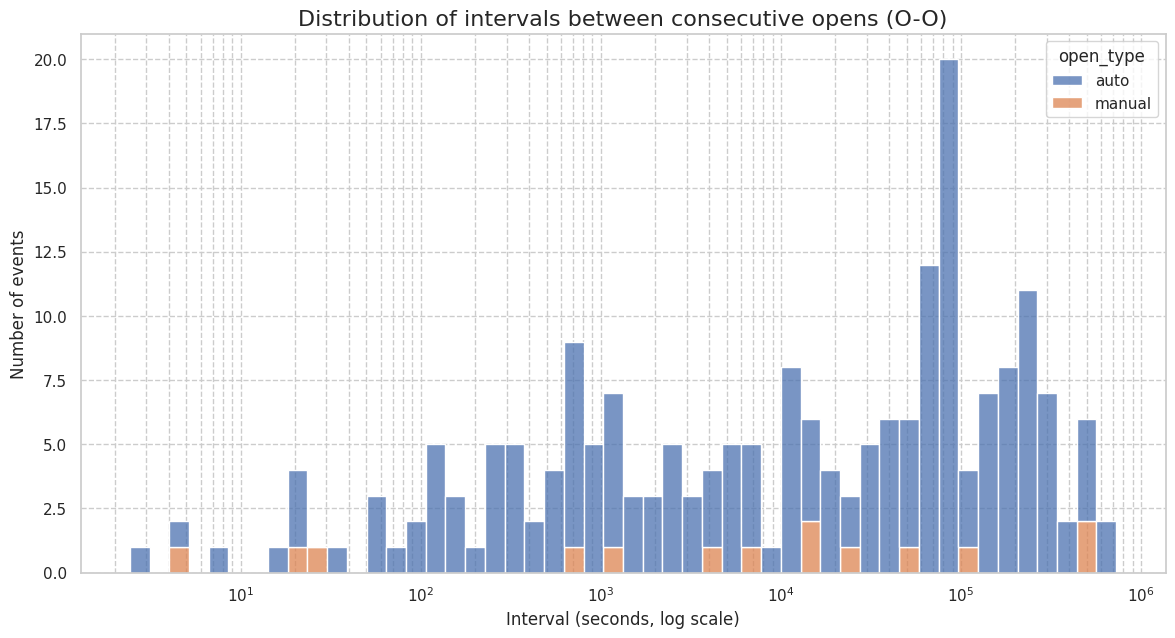

In [136]:
delta_summary = (
    oo_errors.groupby('open_type')['delta_seconds']
    .agg(['count', 'mean', 'median', 'min', 'max'])
)
delta_summary['pctl_25'] = oo_errors.groupby('open_type')['delta_seconds'].quantile(0.25)
delta_summary['pctl_75'] = oo_errors.groupby('open_type')['delta_seconds'].quantile(0.75)
delta_summary['pct_below_1s'] = (
    oo_errors.groupby('open_type')['delta_seconds']
    .apply(lambda s: (s < 1).mean() * 100)
)

print('Time between consecutive opened events (O-O errors):') 
display(delta_summary.round(4))

# Store key metrics for final report
if 'auto' in delta_summary.index:
    auto_pct_below_1s = float(delta_summary.loc['auto', 'pct_below_1s'])
    auto_min_delta_sec = float(delta_summary.loc['auto', 'min'])
else:
    auto_pct_below_1s = 0.0
    auto_min_delta_sec = float('nan')

plt.figure(figsize=(14, 7))
# use an existing column for hue; 'open_type' is present on oo_errors
sns.histplot(
    data=oo_errors,
    x='delta_seconds',
    hue='open_type',
    log_scale=True,
    multiple="stack",
    bins=50
)
plt.title('Distribution of intervals between consecutive opens (O-O)', fontsize=16)
plt.xlabel('Interval (seconds, log scale)')
plt.ylabel('Number of events')
plt.grid(True, which="both", ls="--")
plt.show()

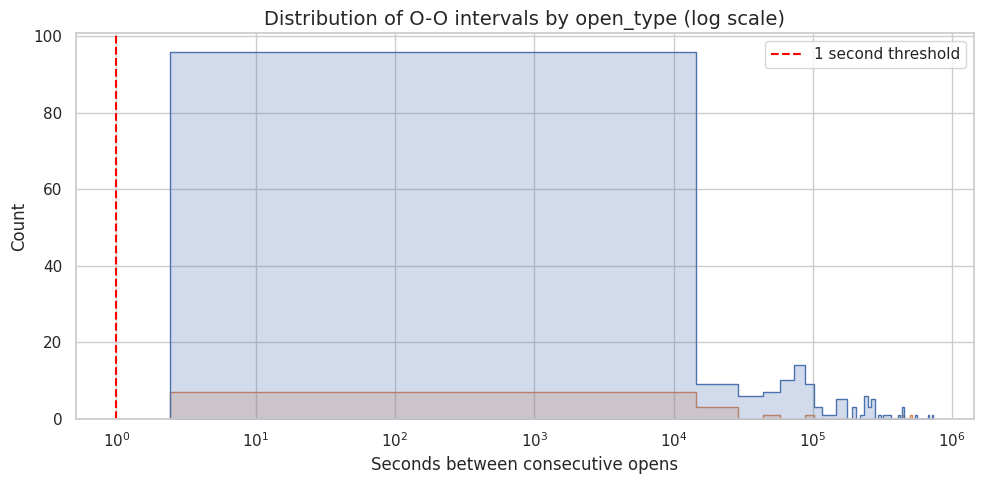

In [137]:
positive_oo = oo_errors[oo_errors['delta_seconds'] > 0]
if not positive_oo.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=positive_oo,
        x='delta_seconds',
        hue='open_type',
        bins=50,
        element='step',
        common_norm=False
    )
    plt.axvline(1, color='red', linestyle='--', label='1 second threshold')
    plt.xscale('log')
    plt.title('Distribution of O-O intervals by open_type (log scale)')
    plt.xlabel('Seconds between consecutive opens')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Part 2 · Baseline Analysis (Last-Open-Wins)

Construct sessions with conservative last-open-wins heuristic as baseline for comparison.

In [138]:
def find_episodes_low(user_events: pd.DataFrame) -> List[Dict[str, Any]]:
    """Match sessions: last opened overrides earlier opens until next closed."""
    episodes: List[Dict[str, Any]] = []
    open_event: Dict[str, Any] | None = None

    for _, row in user_events.iterrows():
        if row['event'] == 'opened':
            open_event = {
                'user_id': row['user_id'],
                'open_type': row['open_type'],
                'open_timestamp': row['timestamp'],
            }
        elif row['event'] == 'closed':
            if open_event is None:
                continue
            episodes.append({
                'user_id': open_event['user_id'],
                'open_type': open_event['open_type'],
                'open_timestamp': open_event['open_timestamp'],
                'close_timestamp': row['timestamp'],
            })
            open_event = None

    return episodes

episodes_records: List[Dict[str, Any]] = []
for user_id, user_events in df_sorted.groupby('user_id', sort=False):
    episodes_records.extend(find_episodes_low(user_events))

low_results_df = pd.DataFrame(episodes_records)
if low_results_df.empty:
    raise RuntimeError('No sessions matched with LOW heuristic.')

low_results_df['duration'] = low_results_df['close_timestamp'] - low_results_df['open_timestamp']
low_results_df['duration_seconds'] = low_results_df['duration'].dt.total_seconds()
low_results_df = low_results_df[low_results_df['duration_seconds'] > 0].copy()
low_results_df['log_duration'] = np.log1p(low_results_df['duration_seconds'])

print(f'Baseline (LOW) sessions: {len(low_results_df):,}')
display(low_results_df.head())

Baseline (LOW) sessions: 1,622


,user_id,open_type,open_timestamp,close_timestamp,duration,duration_seconds,log_duration
0,1,auto,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077,0 days 00:10:43.954000,643.9540,6.4692
1,1,manual,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609,0 days 02:18:05.974000,"8,285.9740",9.0224
2,1,manual,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885,0 days 00:18:56.113000,"1,136.1130",7.0362
3,1,manual,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,0 days 00:00:00.748000,0.7480,0.5585
4,1,manual,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775,0 days 02:00:27.188000,"7,227.1880",8.8857


In [139]:
low_stats = low_results_df.groupby('open_type')['duration_seconds'].describe()
low_skew = low_results_df.groupby('open_type')['duration_seconds'].skew().rename('skew')

print('Baseline duration statistics (seconds):')
display(low_stats)
print('\nSkewness:')
display(low_skew.to_frame())

Baseline duration statistics (seconds):


,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,"1,000.0000","6,323.4464","28,626.9128",0.1540,35.1955,184.8205,"1,195.7368","409,873.7480"
manual,622.0000,"1,470.2599","10,725.4274",0.0150,2.1513,12.0590,135.6637,"180,918.6940"



Skewness:


,skew
open_type,
auto,8.5205
manual,12.5223


In [140]:
manual_low = low_results_df.loc[low_results_df['open_type'] == 'manual', 'duration_seconds']
auto_low = low_results_df.loc[low_results_df['open_type'] == 'auto', 'duration_seconds']

low_mwu = pg.mwu(manual_low, auto_low, alternative='two-sided')
low_mwu_p_value = float(low_mwu['p-val'].iloc[0])
low_mwu_cles = float(low_mwu['CLES'].iloc[0])

print('Baseline Mann–Whitney U test:')
display(low_mwu[['U-val', 'p-val', 'CLES', 'RBC']])
print(f'\nP-value: {low_mwu_p_value:.4g}')
print(f'CLES (auto > manual): {(1 - low_mwu_cles) * 100:.2f}%')

Baseline Mann–Whitney U test:


,U-val,p-val,CLES,RBC
MWU,"156,800.5000",0.0000,0.2521,-0.4958



P-value: 1.995e-63
CLES (auto > manual): 74.79%


## Part 3 · LIFO Stack Analysis

Reconstruct sessions with LIFO stack to correctly handle nested O-O-C sequences.

In [141]:
def find_episodes_lifo(user_events: pd.DataFrame) -> List[Dict[str, Any]]:
    """LIFO stack sessionizer for nested open-close sequences."""
    user_events = user_events.sort_values('timestamp')
    open_stack: List[Any] = []
    sessions: List[Dict[str, Any]] = []
    
    for row in user_events.itertuples(index=False):
        if row.event == 'opened':
            open_stack.append(row)
        elif row.event == 'closed' and open_stack:
            open_row = open_stack.pop()
            sessions.append({
                'user_id': row.user_id,
                'open_timestamp': open_row.timestamp,
                'close_timestamp': row.timestamp,
                'open_type': open_row.open_type,
            })
    return sessions

lifo_records: List[Dict[str, Any]] = []
for user_id, user_events in df_sorted.groupby('user_id', sort=False):
    lifo_records.extend(find_episodes_lifo(user_events))

lifo_results_df = pd.DataFrame(lifo_records)
if lifo_results_df.empty:
    raise RuntimeError('LIFO sessionizer produced no sessions.')

lifo_results_df['duration_seconds'] = (
    lifo_results_df['close_timestamp'] - lifo_results_df['open_timestamp']
).dt.total_seconds()
lifo_results_df = lifo_results_df[lifo_results_df['duration_seconds'] > 0].copy()
lifo_results_df['log_duration'] = np.log1p(lifo_results_df['duration_seconds'])

print(f'LIFO sessions: {len(lifo_results_df):,}')
display(lifo_results_df.head())

LIFO sessions: 1,630


,user_id,open_timestamp,close_timestamp,open_type,duration_seconds,log_duration
0,1,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077,auto,643.9540,6.4692
1,1,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609,manual,"8,285.9740",9.0224
2,1,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885,manual,"1,136.1130",7.0362
3,1,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,manual,0.7480,0.5585
4,1,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775,manual,"7,227.1880",8.8857


In [142]:
lifo_stats = lifo_results_df.groupby('open_type')['duration_seconds'].describe()
lifo_skew = lifo_results_df.groupby('open_type')['duration_seconds'].skew().rename('skew')

print('LIFO duration statistics (seconds):')
display(lifo_stats)
print('\nSkewness:')
display(lifo_skew.to_frame())

LIFO duration statistics (seconds):


,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,"1,005.0000","6,952.0934","31,280.5705",0.1540,35.4880,185.7860,"1,233.8670","409,873.7480"
manual,625.0000,"1,672.7973","11,817.0195",0.0150,2.1760,12.2840,138.4740,"180,918.6940"



Skewness:


,skew
open_type,
auto,8.0055
manual,11.1858


In [143]:
manual_lifo = lifo_results_df.loc[lifo_results_df['open_type'] == 'manual', 'duration_seconds']
auto_lifo = lifo_results_df.loc[lifo_results_df['open_type'] == 'auto', 'duration_seconds']

lifo_mwu = pg.mwu(manual_lifo, auto_lifo, alternative='two-sided')
lifo_mwu_p_value = float(lifo_mwu['p-val'].iloc[0])
lifo_mwu_cles = float(lifo_mwu['CLES'].iloc[0])

print('LIFO Mann–Whitney U test:')
display(lifo_mwu[['U-val', 'p-val', 'CLES', 'RBC']])
print(f'\nP-value: {lifo_mwu_p_value:.4g}')
print(f'CLES (auto > manual): {(1 - lifo_mwu_cles) * 100:.2f}%')

lifo_median_manual = float(manual_lifo.median())
lifo_median_auto = float(auto_lifo.median())

LIFO Mann–Whitney U test:


,U-val,p-val,CLES,RBC
MWU,"159,340.5000",0.0000,0.2537,-0.4926



P-value: 6.135e-63
CLES (auto > manual): 74.63%


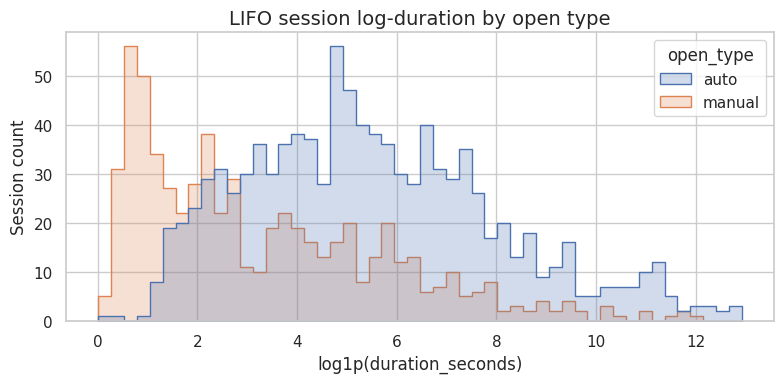

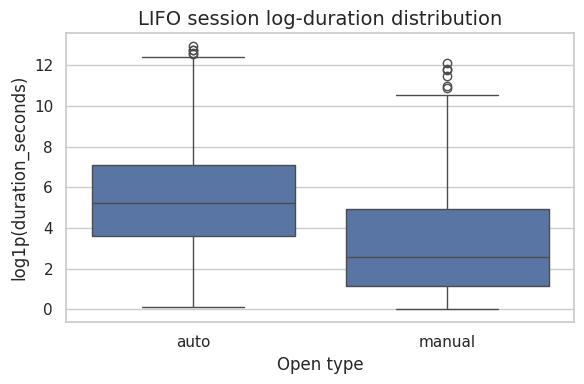

In [144]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(
    data=lifo_results_df,
    x='log_duration',
    hue='open_type',
    element='step',
    bins=50,
    ax=ax,
)
ax.set_xlabel('log1p(duration_seconds)')
ax.set_ylabel('Session count')
ax.set_title('LIFO session log-duration by open type')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=lifo_results_df, x='open_type', y='log_duration', ax=ax)
ax.set_xlabel('Open type')
ax.set_ylabel('log1p(duration_seconds)')
ax.set_title('LIFO session log-duration distribution')
plt.tight_layout()
plt.show()

In [145]:
comparison_df = pd.DataFrame({
    'LOW_count': low_results_df.groupby('open_type')['duration_seconds'].size(),
    'LOW_median_sec': low_results_df.groupby('open_type')['duration_seconds'].median(),
    'LIFO_count': lifo_results_df.groupby('open_type')['duration_seconds'].size(),
    'LIFO_median_sec': lifo_results_df.groupby('open_type')['duration_seconds'].median(),
})
comparison_df = comparison_df.sort_index()

print('Baseline vs LIFO comparison:')
display(comparison_df)

Baseline vs LIFO comparison:


,LOW_count,LOW_median_sec,LIFO_count,LIFO_median_sec
open_type,,,,
auto,1000,184.8205,1005,185.7860
manual,622,12.0590,625,12.2840


## Part 4 · Sensitivity Analysis (Timeout Capping)

Apply 99th-percentile cap to LIFO durations to verify statistical significance persists after trimming extreme outliers.

In [146]:
MAX_DURATION_SEC = float(lifo_results_df['duration_seconds'].quantile(0.99))
print(f"99th percentile cap: {MAX_DURATION_SEC:,.2f} seconds (~{MAX_DURATION_SEC / 3600:.2f} hours)")

capped_lifo_df = lifo_results_df.copy()
capped_lifo_df['capped_duration_sec'] = capped_lifo_df['duration_seconds'].clip(upper=MAX_DURATION_SEC)
capped_lifo_df['capped_log_duration'] = np.log1p(capped_lifo_df['capped_duration_sec'])

num_capped = (capped_lifo_df['duration_seconds'] > MAX_DURATION_SEC).sum()
print(f'Sessions capped: {num_capped} of {len(capped_lifo_df)} ({num_capped / len(capped_lifo_df) * 100:.2f}%)')

99th percentile cap: 99,948.95 seconds (~27.76 hours)
Sessions capped: 17 of 1630 (1.04%)


In [147]:
capped_stats = capped_lifo_df.groupby('open_type')['capped_duration_sec'].describe()
print('Capped LIFO duration statistics (seconds):')
display(capped_stats)

Capped LIFO duration statistics (seconds):


,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,"1,005.0000","5,173.2987","17,159.9561",0.1540,35.4880,185.7860,"1,233.8670","99,948.9480"
manual,625.0000,"1,440.7955","8,946.4175",0.0150,2.1760,12.2840,138.4740,"99,948.9480"


In [148]:
manual_capped_log = capped_lifo_df.loc[capped_lifo_df['open_type'] == 'manual', 'capped_log_duration']
auto_capped_log = capped_lifo_df.loc[capped_lifo_df['open_type'] == 'auto', 'capped_log_duration']

welch_test = pg.ttest(manual_capped_log, auto_capped_log, correction=True)
capped_welch_p_value = float(welch_test['p-val'].iloc[0])

print("Welch's t-test on capped log-durations:")
display(welch_test[['T', 'dof', 'p-val', 'cohen-d']])
print(f'\nCapped Welch p-value: {capped_welch_p_value:.4g}')
print(f'Baseline LIFO MWU p-value: {lifo_mwu_p_value:.4g}')
print('\nConclusion: Statistical significance preserved after capping extreme outliers.')

Welch's t-test on capped log-durations:


,T,dof,p-val,cohen-d
T-test,-17.3792,"1,329.5719",0.0000,0.8840



Capped Welch p-value: 4.006e-61
Baseline LIFO MWU p-value: 6.135e-63

Conclusion: Statistical significance preserved after capping extreme outliers.


In [149]:
# Summary tables for reporting
manual_count = int(lifo_results_df[lifo_results_df['open_type'] == 'manual'].shape[0])
auto_count = int(lifo_results_df[lifo_results_df['open_type'] == 'auto'].shape[0])
max_duration_hours = MAX_DURATION_SEC / 3600

summary_metrics = pd.DataFrame({
    'metric': [
        'manual_sessions',
        'auto_sessions',
        'manual_median_sec',
        'auto_median_sec',
        'lifo_mwu_p_value',
        'lifo_cles_auto_gt_manual_pct',
        'capped_welch_p_value',
        'timeout_cap_hours',
        'auto_oo_pct_below_1s',
        'auto_oo_min_sec'
    ],
    'value': [
        manual_count,
        auto_count,
        lifo_median_manual,
        lifo_median_auto,
        lifo_mwu_p_value,
        (1 - lifo_mwu_cles) * 100,
        capped_welch_p_value,
        max_duration_hours,
        auto_pct_below_1s,
        auto_min_delta_sec
    ]
})

display(Markdown('### Key Metrics Summary'))
display(summary_metrics)

### Key Metrics Summary

,metric,value
0,manual_sessions,625.0000
1,auto_sessions,"1,005.0000"
2,manual_median_sec,12.2840
3,auto_median_sec,185.7860
4,lifo_mwu_p_value,0.0000
5,lifo_cles_auto_gt_manual_pct,74.6324
6,capped_welch_p_value,0.0000
7,timeout_cap_hours,27.7636
8,auto_oo_pct_below_1s,0.0000
9,auto_oo_min_sec,2.4260
